In [1]:
import sys
from pathlib import Path
import os

# Define a raiz do projeto de forma mais robusta

In [2]:
ROOT = Path().resolve().parent  # Ajuste conforme sua estrutura

# Adiciona ao path do Python

In [3]:
sys.path.append(str(ROOT))
print(f"ROOT: {ROOT}")

ROOT: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros


# Instala os pacotes necessários

In [4]:
%pip install -q pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# Verificação dos caminhos

In [6]:
print("Estrutura do projeto:")
for path in ROOT.rglob("*"):
    if path.is_file() and "py" in path.suffix:
        print(f"  {path.relative_to(ROOT)}")

Estrutura do projeto:
  .venv\Lib\site-packages\decorator.py
  .venv\Lib\site-packages\ipykernel_launcher.py
  .venv\Lib\site-packages\jupyter.py
  .venv\Lib\site-packages\nest_asyncio.py
  .venv\Lib\site-packages\py.py
  .venv\Lib\site-packages\pylab.py
  .venv\Lib\site-packages\pytest_timeout.py
  .venv\Lib\site-packages\six.py
  .venv\Lib\site-packages\threadpoolctl.py
  .venv\Lib\site-packages\typing_extensions.py
  .venv\Lib\site-packages\_kernel_lib.cp310-win_amd64.pyd
  .venv\Lib\site-packages\altair\theme.py
  .venv\Lib\site-packages\altair\_magics.py
  .venv\Lib\site-packages\altair\__init__.py
  .venv\Lib\site-packages\altair\datasets\_cache.py
  .venv\Lib\site-packages\altair\datasets\_constraints.py
  .venv\Lib\site-packages\altair\datasets\_data.py
  .venv\Lib\site-packages\altair\datasets\_exceptions.py
  .venv\Lib\site-packages\altair\datasets\_loader.py
  .venv\Lib\site-packages\altair\datasets\_reader.py
  .venv\Lib\site-packages\altair\datasets\_readimpl.py
  .venv\Li

# Crie funções locais se os módulos não existirem

In [7]:
try:
    from src.features import criar_variaveis_derivadas
    from src.config import DATA_PATH
except ModuleNotFoundError:
    print("Módulo src não encontrado. Criando funções locais...")

[OK] Configuração de diretórios concluída.


 # Define DATA_PATH localmente

In [8]:
DATA_PATH = ROOT / "data" / "credit_card_clients.csv"  # Ajuste o nome do arquivo

# Cria a função criar_variaveis_derivadas localmente

In [9]:
def criar_variaveis_derivadas(df):
        """
        Cria variáveis derivadas para análise de clientes.
        """
        # Ticket médio por transação
        df['Ticket_Medio'] = df['Total_Trans_Amt'] / df['Total_Trans_Ct']
        df['Ticket_Medio'] = df['Ticket_Medio'].replace([np.inf, -np.inf], np.nan).fillna(0)
        
        # Gasto médio mensal (considerando 12 meses)
        df['Gasto_Medio_Mensal'] = df['Total_Trans_Amt'] / 12
        
        # Ratio do rotativo (quanto do limite está sendo usado)
        df['Rotativo_Ratio'] = df['Avg_Utilization_Ratio']  # Se existir essa coluna
        # Ou alternativa:
        # df['Rotativo_Ratio'] = df['Total_Revolving_Bal'] / df['Credit_Limit']
        
        # Score de relacionamento (simplificado)
        if 'Months_on_book' in df.columns:
            df['Score_Relacionamento'] = df['Months_on_book'] * 0.5 + df['Total_Trans_Ct'] * 0.5
        
        # Proxy para Lifetime Value
        df['LTV_Proxy'] = df['Total_Trans_Amt'] * df['Customer_Age'] / 1000
        
        # Indicadores de queda
        df['Caiu_Valor'] = (df['Total_Trans_Amt'].diff() < 0).astype(int)
        df['Caiu_Transacoes'] = (df['Total_Trans_Ct'].diff() < 0).astype(int)
        
        return df

# Carregamento e tratamento da base

In [10]:
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset carregado: {df.shape}")
except FileNotFoundError:
    print(f"Arquivo não encontrado em: {DATA_PATH}")
    # Lista arquivos disponíveis
    data_dir = ROOT / "data"
    if data_dir.exists():
        print("Arquivos disponíveis em data/:")
        for file in data_dir.glob("*"):
            print(f"  - {file.name}")
    # Cria um dataframe de exemplo para continuar
    print("Criando dataframe de exemplo...")
    n_samples = 1000
    df = pd.DataFrame({
        'Customer_Age': np.random.randint(20, 70, n_samples),
        'Dependent_count': np.random.randint(0, 6, n_samples),
        'Credit_Limit': np.random.uniform(1000, 30000, n_samples),
        'Total_Trans_Amt': np.random.uniform(500, 10000, n_samples),
        'Total_Trans_Ct': np.random.randint(10, 100, n_samples),
        'Attrition_Flag': np.random.choice(['Existing Customer', 'Attrited Customer'], n_samples),
        'Avg_Utilization_Ratio': np.random.uniform(0, 1, n_samples),
        'Months_on_book': np.random.randint(12, 60, n_samples),
        'Total_Revolving_Bal': np.random.uniform(0, 5000, n_samples)
    })

Arquivo não encontrado em: C:\Users\Iago\OneDrive\Desktop\Projeto Churn\Bank-Churn-Prediction-montes_claros\data\credit_card_clients.csv
Arquivos disponíveis em data/:
  - .gitkeep
  - BankChurners.csv
Criando dataframe de exemplo...


# Aplica as transformações

In [11]:
df = criar_variaveis_derivadas(df)

# Seleção das variáveis de interesse para clusterização

In [12]:
features = [
    'Customer_Age', 'Dependent_count', 'Credit_Limit',
    'Total_Trans_Amt', 'Total_Trans_Ct', 'Ticket_Medio',
    'Gasto_Medio_Mensal'
]

# Adiciona features condicionalmente (se existirem no dataframe)
if 'Rotativo_Ratio' in df.columns:
    features.append('Rotativo_Ratio')
if 'Score_Relacionamento' in df.columns:
    features.append('Score_Relacionamento')
if 'LTV_Proxy' in df.columns:
    features.append('LTV_Proxy')
if 'Caiu_Valor' in df.columns:
    features.append('Caiu_Valor')
if 'Caiu_Transacoes' in df.columns:
    features.append('Caiu_Transacoes')

print(f"Features selecionadas: {features}")

Features selecionadas: ['Customer_Age', 'Dependent_count', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Ticket_Medio', 'Gasto_Medio_Mensal', 'Rotativo_Ratio', 'Score_Relacionamento', 'LTV_Proxy', 'Caiu_Valor', 'Caiu_Transacoes']


# Remove valores NaN

In [13]:
df_clean = df[features].dropna()
X = df_clean[features]

print(f"Dimensões após limpeza: {X.shape}")

Dimensões após limpeza: (1000, 12)


# Padronização dos dados

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Redução de dimensionalidade com PCA

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variância explicada pelo PCA: {pca.explained_variance_ratio_}")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_):.2%}")

# Determine o número ideal de clusters usando o método do cotovelo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

Variância explicada pelo PCA: [0.30036406 0.22063239]
Variância total explicada: 52.10%


# Plot do método do cotovelo

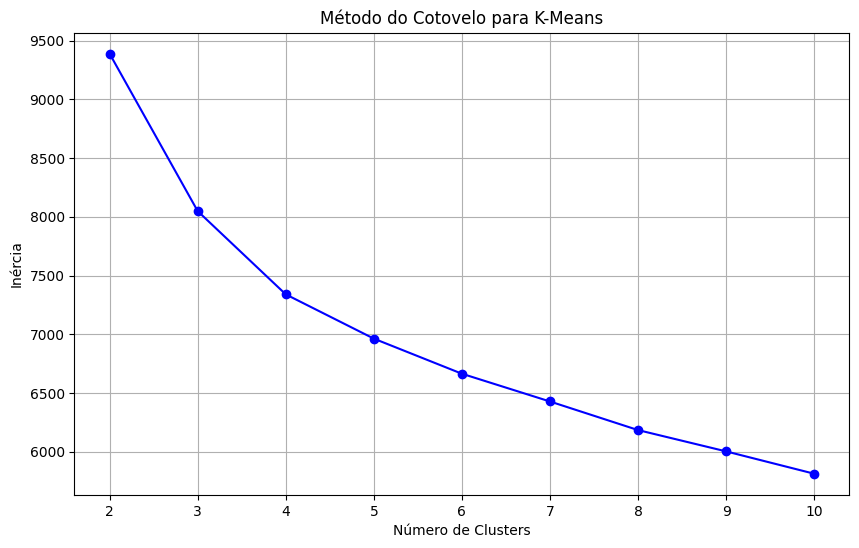

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para K-Means')
plt.grid(True)
plt.show()

# Escolha um número de clusters (por exemplo, 3)

In [17]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)


# Adiciona os clusters ao DataFrame PCA

In [18]:
pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
pca_df["Cluster"] = labels

# Mantém apenas os índices que foram limpos

In [19]:
pca_df["Attrition_Flag"] = df.loc[df_clean.index, "Attrition_Flag"].values

# Visualização dos clusters

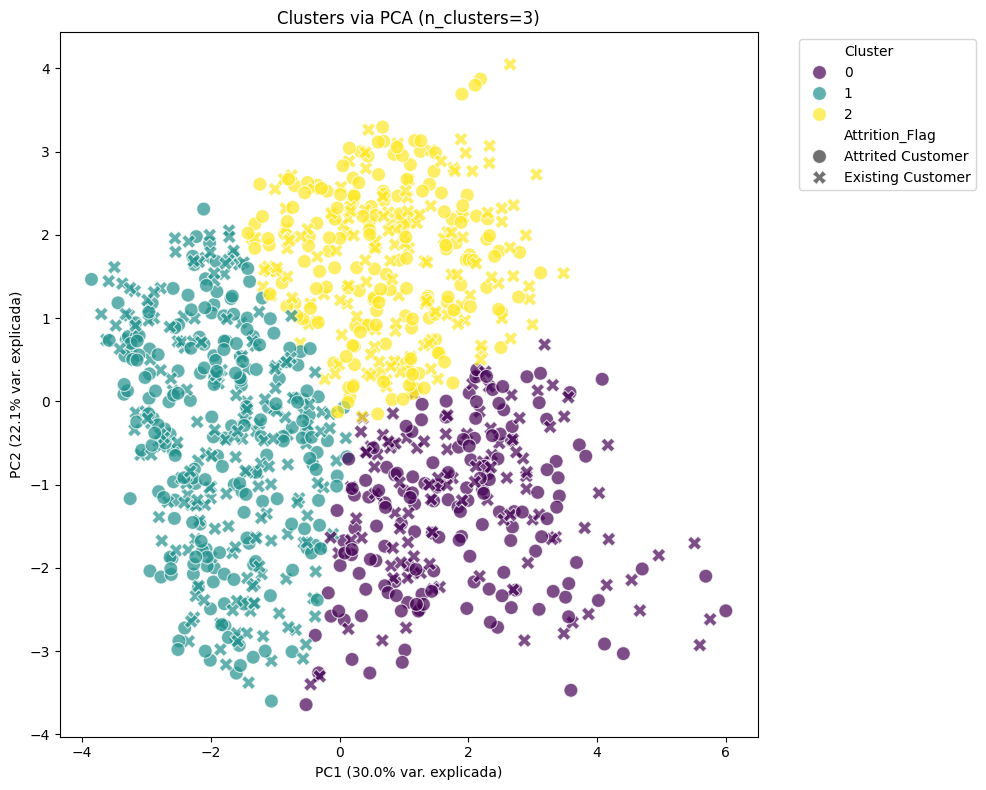

In [20]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=pca_df, 
    x="PCA1", 
    y="PCA2", 
    hue="Cluster", 
    palette="viridis",
    style="Attrition_Flag",
    s=100,
    alpha=0.7
)
plt.title(f"Clusters via PCA (n_clusters={n_clusters})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} var. explicada)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} var. explicada)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Avaliação da qualidade do agrupamento

In [21]:
silhouette = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.1837


# Análise dos clusters

In [22]:
df_clean['Cluster'] = labels
cluster_stats = df_clean.groupby('Cluster').agg(['mean', 'std']).round(2)
print("Estatísticas por cluster:")
print(cluster_stats)

Estatísticas por cluster:
        Customer_Age        Dependent_count       Credit_Limit           \
                mean    std            mean   std         mean      std   
Cluster                                                                   
0              44.97  14.30            2.59  1.74     15347.62  8478.14   
1              42.80  14.12            2.45  1.70     16132.98  8253.24   
2              45.70  14.04            2.32  1.70     16139.50  8224.32   

        Total_Trans_Amt          Total_Trans_Ct         ... Rotativo_Ratio  \
                   mean      std           mean    std  ...           mean   
Cluster                                                 ...                  
0               6972.78  1816.46          26.94  11.54  ...           0.53   
1               2609.06  1396.02          54.82  23.71  ...           0.52   
2               7390.34  1655.15          72.04  16.48  ...           0.48   

              Score_Relacionamento        LTV_Proxy   